# Divisione fra Contee #

In questo notebook si analizza se possa essere sensato separare il dataset di lavoro a seconda di una delle tre contee di appartenza (feature `regionidcounty`).

In [1]:
# Libraries
import pandas as pd
import numpy  as np
import re
import warnings
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

from sklearn.cluster       import KMeans
from sklearn.metrics       import accuracy_score
from sklearn.metrics       import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble      import RandomForestClassifier

warnings.filterwarnings('ignore')

## Lettura dei dati ##

In [2]:
# local file paths
dir_name = 'preparazione'

fp_xtrain = dir_name + "/X_train.csv"
fp_ytrain = dir_name + "/y_train.csv"
fp_xval   = dir_name + "/X_val.csv"
fp_yval   = dir_name + "/y_val.csv"
fp_xtest  = dir_name + "/X_test.csv"
fp_ytest  = dir_name + "/y_test.csv"

Lettura dei dati preprocessati:

In [3]:
# Reading dataframes
X_train = pd.read_csv(fp_xtrain, low_memory=False)
y_train = pd.read_csv(fp_ytrain, low_memory=False)
X_val   = pd.read_csv(fp_xval,   low_memory=False)
y_val   = pd.read_csv(fp_yval,   low_memory=False)
X_test  = pd.read_csv(fp_xtest,  low_memory=False)
y_test  = pd.read_csv(fp_ytest,  low_memory=False)

In [4]:
# Removes from the given dataframe the column with the given name
def remove_column(df, col_names):
    df.drop(col_names, axis=1, inplace=True)
    return df

In [5]:
for X in [X_train, X_val, X_test]:
    X = remove_column(X, ['parcelid'])

In [6]:
# Prints all dataframes shape
def dimensionality(y=False):
    print(f'X_train {  X_train.shape}')
    print(f'X_val   {    X_val.shape}')
    print(f'X_test  {   X_test.shape}')
    if y:
        print(f'y_train { y_train.shape}')
        print(f'y_val   {   y_val.shape}')
        print(f'y_test  {  y_test.shape}')

In [7]:
dimensionality(y=True)

X_train (99709, 72)
X_val   (33572, 72)
X_test  (33567, 72)
y_train (99709, 1)
y_val   (33572, 1)
y_test  (33567, 1)


In [8]:
print(*X_train.columns, sep='\n')

bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
calculatedfinishedsquarefeet
finishedsquarefeet12
fireplacecnt
latitude
longitude
lotsizesquarefeet
rawcensustractandblock
regionidcity
regionidzip
roomcnt
unitcnt
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
landtaxvaluedollarcnt
taxamount
int_transactiondate
period_mean_price
neighborhood_mean_price
living_area_prop
tax_ratio
tax_prop
buildingqualitytypeid_na_flag
unitcnt_na_flag
assessmentyear_2015.0
fips_6037.0
fips_6059.0
fips_6111.0
heatingorsystemtypeid_1.0
heatingorsystemtypeid_2.0
heatingorsystemtypeid_6.0
heatingorsystemtypeid_7.0
heatingorsystemtypeid_10.0
heatingorsystemtypeid_11.0
heatingorsystemtypeid_12.0
heatingorsystemtypeid_13.0
heatingorsystemtypeid_18.0
heatingorsystemtypeid_20.0
heatingorsystemtypeid_24.0
poolcnt_1.0
propertycountylandusecode_0100
propertycountylandusecode_0101
propertycountylandusecode_010C
propertycountylandusecode_122
propertycountylandusecode_34
propertycountylandusecode_r

Colonne che discriminino la contea:

In [9]:
regionids = ['regionidcounty_1286.0', 'regionidcounty_2061.0', 'regionidcounty_3101.0']

region_names = np.array([   'A',    'B',    'C'])
region_ids   = np.array(['1286', '2061', '3101'])

## Clustering ##

Verifica se un algoritmo di __clustering__ sia in grado di individuare le differenti contee.

Per farlo lavoro esclusivamente sul dataset di train, costruendo un nuova dataset:
- `X'`, ossia il dataset X_train senza le tre colonne `regioid_county`
- `y'`, che sfrutta un label encoding con etichette 0, 1 e 2 a seconda della contea di appartenenza 

In [10]:
# Returns a new dataframe X without region infos, which are returned in y vector in 0, 1, 2 encoding
def get_X_y(X):
    X_ = X.copy() 
    y_ = X_.loc[:, regionids]  
    y_.loc[:,['region']] =\
        y_.loc[:,regionids[0]] * 0 +\
        y_.loc[:,regionids[1]] * 1 +\
        y_.loc[:,regionids[2]] * 2
    X_ = remove_column(X_, regionids)
    y_ = remove_column(y_, regionids)
    y_ = y_.values.ravel().astype(np.int64)
    return X_, y_

### k-means 

Utilizzo di un algoritmo di clustering __k-means__.

In [11]:
def kmeans_clustering(X):
    kmeans = KMeans(n_clusters=3).fit(X)
    print(kmeans.labels_)
    return kmeans, kmeans.labels_

In [12]:
# Returns the accuracy score given actual values and predictions
def accuracy(y_true, y_pred, verbose = False):
    acc = accuracy_score(y_true, y_pred)
    if verbose:
        print(y_pred [:35])
        print(y_true [:35])
        print('Accuracy: ', acc)
    return acc

In [13]:
X_clu, y_true = get_X_y(X_train)

In [14]:
_, y_pred = kmeans_clustering(X_clu)

[0 0 0 ... 0 0 0]


In [15]:
print('True     ', y_true[:35],)
print('Predicted', y_pred[:35],)

True      [0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 2 2 0 2 2 0 2 2]
Predicted [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Sembra che l'algoritmo abbia individuato un cluster molto grande rispetto agli altri.

In [16]:
_, y_pred = kmeans_clustering(X_clu)

[1 1 1 ... 1 1 1]


In [17]:
for i in range(3):
    print(f'Occorrenze Regione{region_names[i]} : {np.bincount(y_true)[i]}')
print()

for i in range(3):
    print(f'Occorrenze Cluster{i} : {np.bincount(y_pred)[i]}')

Occorrenze RegioneA : 26819
Occorrenze RegioneB : 8119
Occorrenze RegioneC : 64771

Occorrenze Cluster0 : 7662
Occorrenze Cluster1 : 91784
Occorrenze Cluster2 : 263


Quasi tutte le instanze infatti sono nel cluster 1, le proporzioni tra cluster non sono quelle attese.
L'algoritmo trova un cluster molto grande.

Per indagarne meglio il fenomeno, è attuata una __riduzione dimensionale__ usando la Principal Componenet Analysis per ottenere un'informazione bidimensionale capace fornire una visualizzazione sintetica.

## Principal Componenet Analysis ##

In [18]:
X_pca, y_pca = get_X_y(X_train)

In [19]:
X_train.shape

(99709, 72)

In [20]:
X_pca.shape

(99709, 69)

In [21]:
y_pca.shape

(99709,)

Riduco X a due dimensioni.

In [22]:
X_pca_2 = PCA(n_components=2).fit_transform(X_pca)

In [23]:
X_pca_2.shape

(99709, 2)

Sfrutto la bidimensionalità per ottenere una rappresentazione grafica.

In [24]:
def plot_regions(X, y, title="", file_name=''):
    
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(10,6))

    colors = np.array([
        (1., .1, .1, .3),
        (.1, 1., .1, .3),
        (.1, .1, 1., .3)]
    )

    # scatter is ismilar to plot, additionally a color per point is provided
    scatter = ax.scatter(X[:,0],X[:,1], c=colors[y], label=region_ids[y])

    handles = []
    for c,l in zip(colors, region_ids):
        handles.append(mpatches.Patch(color=c, label=l))
    plt.legend(handles=handles)

    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.set_title(title, fontsize=20)
    ax.grid(linestyle=':', linewidth=.5)
    
    if file_name != '':
        fig.savefig('images/' + file_name + '.jpg')

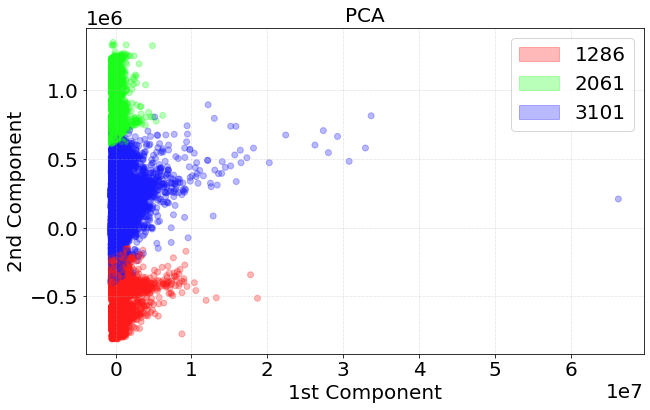

In [25]:
plot_regions(X_pca_2, y_pca, title="PCA", file_name='regioni')

Le contee sembrano distribuirsi in regioni continue nello spazio.

Indago con un dataset bisimensionale il comportamento di __k-means__ sfruttando la rappresentazione grafica.

In [26]:
est, y_pred = kmeans_clustering(X_pca_2)

[0 0 0 ... 0 0 0]


In [27]:
print('True     ', y_true[:35],)
print('Predicted', y_pred[:35],)

True      [0 2 2 0 2 0 1 0 0 2 0 0 2 2 2 2 2 1 2 2 2 0 2 2 2 2 1 2 2 0 2 2 0 2 2]
Predicted [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


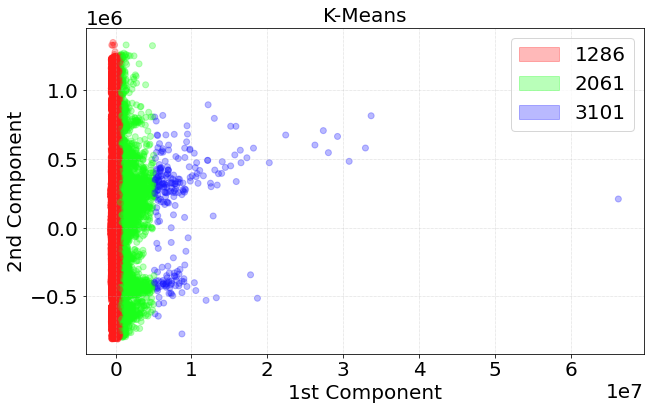

In [28]:
plot_regions(X_pca_2, y_pred, title="K-Means", file_name='k_means')

Il clustering __k_means__ non individua in maniera precisa i tre cluster, poiché ha il limite di individuare specialmente cluster circolari, differenti da questo particolare caso.

Un algoritmo di clustering come __DBSCAN__ non risulterebbe vantaggioso: l'algoritmo individuerebbe alcuni outlier e non sarebbe in grado di separare le contee; questo perché DBSCAN si basa sulla distanza euclidea e le contee non sono ben distanziate nello spazio, DBSCAN non sarebbe in grado di separarli.

## Algoritmo di classificazione ##

Impiego di un algoritmo di __classificazione__ dividendo il dataset di Train a in Train e Test con rapporto 2:1

In [29]:
half = int(len(X_pca)*2/3)

Studio sia il dataset completo che quello ridotto con la PCA

In [30]:
X_class_train   = X_pca  [:half]
X_class_train_2 = X_pca_2[:half]
y_class_train   = y_pca  [:half]


X_class_test    = X_pca  [half:]
X_class_test_2  = X_pca_2[half:]
y_class_test    = y_pca  [half:]

In [31]:
def classifier(X_train, y_train, X_test, y_test):
    rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy: {acc}')
    plot_confusion_matrix(rfc, X_test, y_test)

Usando il dataset con PCA:

Accuracy: 0.9306796642296236


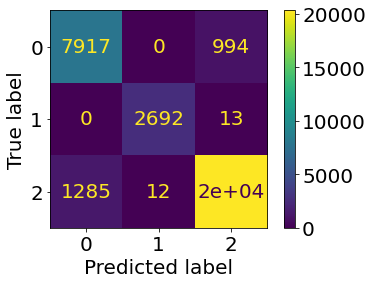

In [32]:
classifier(X_class_train_2, y_class_train, X_class_test_2, y_class_test)

Il classificatore ha una buona accuracy

<br>

Usando il dataset originale:

Accuracy: 1.0


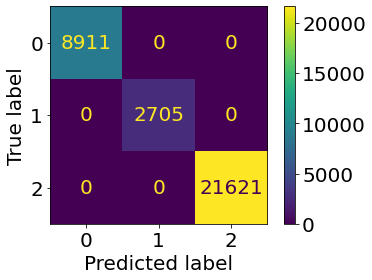

In [33]:
# X con le feature originali
classifier(X_class_train, y_class_train, X_class_test, y_class_test)

La classificazione ha la massima precisione. <br>
Forse nella PCA sono stati inevitabilmente compressi dei dati, che però nelle feature originali portano in maniera silente informazione delle contea (ad esempio  `propertycountylandusecode`, `propertyzoningdesc` o `propertylandusetypeid` potrebbero avere dei codici specifici della contea; oppure `latitude` e `longitude` potrebbero riuscire a separare geograficamente le tre contea). <br>

Provo la classificazione non considerando esplicitamente colonne legate alla contea.

In [34]:
def classifier_remove_col(X_train, y_train, X_test, y_test, rem_col):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    X_tr = remove_column(X_tr, rem_col)
    X_te = remove_column(X_te, rem_col)
    classifier(X_tr, y_train, X_te, y_test)

In [35]:
prop_lti = list(filter(re.compile("^propertylandusetypeid_.*$").match, list(X_train.columns)))
prop_lti

['propertylandusetypeid_31.0',
 'propertylandusetypeid_246.0',
 'propertylandusetypeid_247.0',
 'propertylandusetypeid_248.0',
 'propertylandusetypeid_260.0',
 'propertylandusetypeid_261.0',
 'propertylandusetypeid_263.0',
 'propertylandusetypeid_264.0',
 'propertylandusetypeid_265.0',
 'propertylandusetypeid_266.0',
 'propertylandusetypeid_267.0',
 'propertylandusetypeid_269.0',
 'propertylandusetypeid_275.0']

In [36]:
prop_clc = list(filter(re.compile("^propertycountylandusecode_.*$").match, list(X_train.columns)))
prop_clc

['propertycountylandusecode_0100',
 'propertycountylandusecode_0101',
 'propertycountylandusecode_010C',
 'propertycountylandusecode_122',
 'propertycountylandusecode_34',
 'propertycountylandusecode_rare']

In [37]:
prop_zid = list(filter(re.compile("^propertyzoningdesc_.*$").match, list(X_train.columns)))
prop_zid

['propertyzoningdesc_LAR1',
 'propertyzoningdesc_LAR3',
 'propertyzoningdesc_LARD1.5',
 'propertyzoningdesc_LARS',
 'propertyzoningdesc_LBR1N',
 'propertyzoningdesc_rare']

In [38]:
regions = ['regionidcity', 'regionidzip', 'rawcensustractandblock', 'latitude', 'longitude']
regions

['regionidcity',
 'regionidzip',
 'rawcensustractandblock',
 'latitude',
 'longitude']

In [39]:
fips = list(filter(re.compile("^fips_.*$").match, list(X_train.columns)))
fips

['fips_6037.0', 'fips_6059.0', 'fips_6111.0']

In [40]:
region_about = prop_lti + prop_clc + prop_zid +regions + fips
region_about

['propertylandusetypeid_31.0',
 'propertylandusetypeid_246.0',
 'propertylandusetypeid_247.0',
 'propertylandusetypeid_248.0',
 'propertylandusetypeid_260.0',
 'propertylandusetypeid_261.0',
 'propertylandusetypeid_263.0',
 'propertylandusetypeid_264.0',
 'propertylandusetypeid_265.0',
 'propertylandusetypeid_266.0',
 'propertylandusetypeid_267.0',
 'propertylandusetypeid_269.0',
 'propertylandusetypeid_275.0',
 'propertycountylandusecode_0100',
 'propertycountylandusecode_0101',
 'propertycountylandusecode_010C',
 'propertycountylandusecode_122',
 'propertycountylandusecode_34',
 'propertycountylandusecode_rare',
 'propertyzoningdesc_LAR1',
 'propertyzoningdesc_LAR3',
 'propertyzoningdesc_LARD1.5',
 'propertyzoningdesc_LARS',
 'propertyzoningdesc_LBR1N',
 'propertyzoningdesc_rare',
 'regionidcity',
 'regionidzip',
 'rawcensustractandblock',
 'latitude',
 'longitude',
 'fips_6037.0',
 'fips_6059.0',
 'fips_6111.0']

Accuracy: 0.9923278274212474


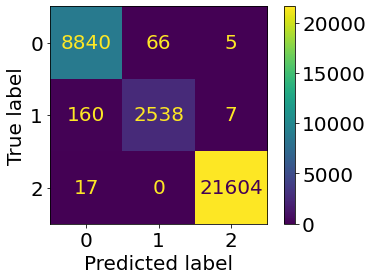

In [41]:
classifier_remove_col(X_class_train, y_class_train, X_class_test, y_class_test, region_about)

La classificazione ha comunque una precisione molto alta. Questo significa che pur rimuovendo le colonne esplicitamente collegate alla contea di appartenenza è comunque possibile individuare un pattern nei dati specifico di una certa contea.

<br>

# Split #

Divisoine del Dataset per del suo `regionidcounty`.

In [42]:
# Returns the X, y dataframes splitted throught counties
def split_regionid(X, y):
    A = X.loc[:,regionids[0]] == 1
    B = X.loc[:,regionids[1]] == 1 
    C = X.loc[:,regionids[2]] == 1    
    return X[A], X[B], X[C], y[A], y[B], y[C]

In [43]:
X_trainA, X_trainB, X_trainC, y_trainA, y_trainB, y_trainC = split_regionid(X_train, y_train)
X_valA,   X_valB,   X_valC,   y_valA,   y_valB,   y_valC   = split_regionid(X_val,   y_val  )
X_testA,  X_testB,  X_testC,  y_testA,  y_testB,  y_testC  = split_regionid(X_test,  y_test )

Mantengo i dataframe in un array.

In [44]:
X_train = np.array([X_trainA, X_trainB, X_trainC], dtype=object)
X_val   = np.array([X_valA,   X_valB,   X_valC  ], dtype=object)
X_test  = np.array([X_testA,  X_testB,  X_testC ], dtype=object)
y_train = np.array([y_trainA, y_trainB, y_trainC], dtype=object)
y_val   = np.array([y_valA,   y_valB,   y_valC  ], dtype=object)
y_test  = np.array([y_testA,  y_testB,  y_testC ], dtype=object)

In [45]:
for X in [X_train, X_val, X_test]:
    for x in X:
        x = remove_column(x, regionids)

In [46]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
            print()

In [47]:
dimensionality(y=True)

X_trainA: (26819, 69)
X_valA:   (9006, 69)
X_testA:  (9085, 69)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 69)
X_valB:   (2658, 69)
X_testB:  (2606, 69)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 69)
X_valC:   (21908, 69)
X_testC:  (21876, 69)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



Le proprozioni fra contea sono circa 3:1:8.

## Salvataggio dei dati ##

Salvataggio dei dati in una dataset apposito con già lo split per contea.

In [48]:
dir_name = 'contea'

for i in range(3):
    X_train[i].to_csv( dir_name + f'/X_train{region_names[i]}.csv',  index=False)
    X_val  [i].to_csv( dir_name + f'/X_val{  region_names[i]}.csv',  index=False)
    X_test [i].to_csv( dir_name + f'/X_test{ region_names[i]}.csv',  index=False)
    y_train[i].to_csv( dir_name + f'/y_train{region_names[i]}.csv',  index=False)
    y_val  [i].to_csv( dir_name + f'/y_val{  region_names[i]}.csv',  index=False)
    y_test [i].to_csv( dir_name + f'/y_test{ region_names[i]}.csv',  index=False)    